# Merging SVGP sub-models using PAPL

This notebook illustrates how to use PAPL (Posterior Aggregation using Pseudo-Likelihood) to train an ensemble of GP classification models and to make predictions with it.

First, let's load some required packages

In [2]:
import numpy as np
import gpflow
import guepard
import matplotlib.pyplot as plt
import scipy.io as sio

from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))

/var/folders/hf/nx4hh6mj3bsfyxc4p3splhxr0000gn/T/ipykernel_70300/4062647756.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


We now load the banana dataset: This is a binary classification problem with two classes. 

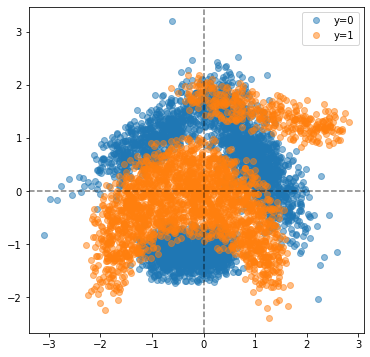

In [15]:
data = sio.loadmat('../data/banana.mat')
Y = data['banana_Y']
X = data['banana_X']

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", alpha=0.5, label="y=0")
ax.plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", alpha=0.5, label="y=1")
ax.axhline(0, color='k', linestyle="dashed", alpha=0.5)
ax.axvline(0, color='k', linestyle="dashed", alpha=0.5)
ax.legend()


We now split the dataset in three, and build a GPR model for each of them

In [4]:
num_split = 3

Xl = np.array_split(X, num_split)  # list of num_split np.array
Yl = np.array_split(Y, num_split)  

kernel = gpflow.kernels.Matern32()

# make submodels and aggregate them
M = get_gpr_submodels(zip(Xl, Yl), kernel, noise_variance=noise_var) # list of num_split GPR models

m_agg = guepard.PAPL(M)

`M` is a list of GPR models, let's plot them

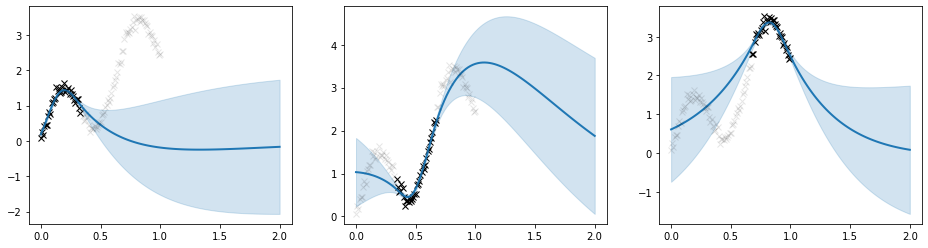

In [5]:
# define plotting helper functions

def plot_mean_conf(x, mean, var, ax, color='C0'):
        ax.plot(x, mean, color, lw=2)
        ax.fill_between(
            x[:, 0],
            mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
            mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
            color=color,
            alpha=0.2,
        )


def plot_model(m, ax, x=np.linspace(0, 1, 101)[:, None], plot_data=True, color='C0'):
    if plot_data:
        X, Y = m.data
        ax.plot(X, Y, "kx", mew=1.)
    
    mean, var = m.predict_f(x)[:2]
    plot_mean_conf(x, mean, var, ax, color)
    
# plot predictions
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
x = np.linspace(0, 2, 101)[:, None]
[plot_model(m, axes[i], x) for i, m in enumerate(M)];
[axes[i].plot(X, Y, 'kx', mew=1., alpha=.1) for i, _ in enumerate(M)];

We can now aggregate the three sub-models using PAPL

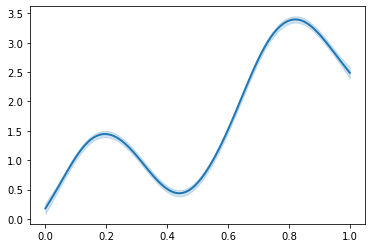

In [6]:
m_papl = guepard.PAPL(M)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_model(m_papl, ax, plot_data=False)

Guepard models inherit from GPflow GPmodels, it is thus possible to interact with them like any other GPflow models:

In [7]:
# print the model parameter summary
gpflow.utilities.print_summary(m_papl)

# Set the value of one parameter
m_papl.kernel.lengthscales.assign(0.3)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ PAPL.kernel.variance               │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    1    │
│ PAPL.models[0].kernel.variance     │           │                  │         │             │         │         │         │
│ PAPL.models[1].kernel.variance     │           │                  │         │             │         │         │         │
│ PAPL.models[2].kernel.variance     │           │                  │         │             │         │         │         │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ PAPL.k

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-1.0502256128148466>

## PAPL Model training

Guepard models can be trained like any other GPflow model

In [8]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_papl.training_loss, m_papl.trainable_variables, options=dict(maxiter=100))
print_summary(m_papl)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ PAPL.kernel.variance               │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.69519    │
│ PAPL.models[0].kernel.variance     │           │                  │         │             │         │         │            │
│ PAPL.models[1].kernel.variance     │           │                  │         │             │         │         │            │
│ PAPL.models[2].kernel.variance     │           │                  │         │             │         │         │            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼────────

2022-06-23 10:59:41.856672: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Comparison with a GPR model based on the full dataset

In [9]:
# make a GPR model as baseline
m_gpr = gpflow.models.GPR((X, Y), kernel, noise_variance=noise_var)
opt_logs = opt.minimize(m_gpr.training_loss, m_gpr.trainable_variables, options=dict(maxiter=100))
print_summary(m_papl)

# Check "good" match between aggregated model and gpr at training points
mean_papl, var_papl = m_papl.predict_f(X)
mean_gpr, var_gpr = m_gpr.predict_f(X)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ PAPL.kernel.variance               │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 4.04461    │
│ PAPL.models[0].kernel.variance     │           │                  │         │             │         │         │            │
│ PAPL.models[1].kernel.variance     │           │                  │         │             │         │         │            │
│ PAPL.models[2].kernel.variance     │           │                  │         │             │         │         │            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼────────

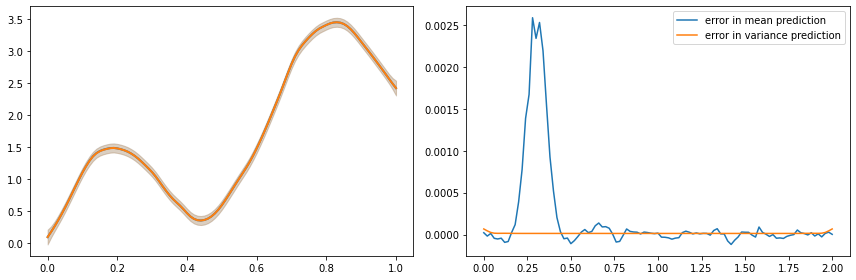

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_model(m_papl, axes[0], plot_data=False)
plot_model(m_gpr, axes[0], plot_data=False, color='C1')

axes[1].plot(x, mean_papl - mean_gpr, label="error in mean prediction")
axes[1].plot(x, np.sqrt(var_papl) - np.sqrt(var_gpr), label="error in variance prediction")
plt.legend()
plt.tight_layout()

On this simple example, predictions from PAPL are can barely be distinguished from the ground truth despite requiring to store and invert matrices that are 1/3rd of the size of a full model.  